In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from datetime import datetime as dt
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

categorical = []
NFOLDS = 3
Seedarray = range(NFOLDS)

In [118]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

def get_lgb_model(Dtrain, Dvalid, isValid=True, bestiter=0, randomseed=0):
    lgbm_params = {'task': 'train',
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    #'max_depth': 15,
                    'num_leaves': 270,
                    'feature_fraction': 0.5,
                    'bagging_fraction': 0.75,
                    'bagging_freq': 2,
                    'learning_rate': 0.016
                  }
    evals_results = {}
    # Train lgb
    if isValid == True:
        lgb_clf = lgb.train(lgbm_params,
                            Dtrain,
                            valid_sets=[Dvalid],
                            valid_names=['valid'],
                            num_boost_round=2500,
                            early_stopping_rounds=50,
                            verbose_eval=50,
                            evals_result=evals_results,
                            feval=None
                           )
    else:
        lgb_clf = lgb.train(lgbm_params,
                            Dtrain,
                            valid_sets=[Dvalid],
                            valid_names=['valid'],
                            num_boost_round=np.uint(bestiter*1.1),
                            verbose_eval=100,
                            feval=None
                           )
    # Plot importances
    lgb.plot_importance(lgb_clf, importance_type="split", title="split")
    plt.show()
    lgb.plot_importance(lgb_clf, importance_type="gain", title='gain')
    plt.show()

    best_iteration = lgb_clf.best_iteration
    print(f'best iteration is {best_iteration}')
    if isValid:
        best_score = evals_results['valid']['rmse'][lgb_clf.best_iteration-1]
        print(f'best score is {best_score}')
    return lgb_clf, best_iteration

def get_lgb_train(trainX, trainy, validX, validy, predictors, categorical):
    Dtrain = lgb.Dataset(trainX.values, label=trainy.values.ravel(), feature_name=predictors, categorical_feature=categorical)
    Dvalid = lgb.Dataset(validX.values, label=validy.values.ravel(), feature_name=predictors, categorical_feature=categorical)
    return Dtrain, Dvalid


In [108]:
# Example For KFold

train = pd.read_feather('hoge')
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])
predictors = train.columns.tolist()

kf = KFold(n_splits=NFOLDS)
lgb_models = []
best_iters = []
preds = pd.DataFrame()

for count, indices in enumerate(kf.split(train, y)):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    lgb_model, bestiter = get_lgb_model(Dtrain, Dvalid, isValid=True)
    del Dtrain, Dvalid; gc.collect()

    test = get_test_forlgb('../features/featured/test/hoge.feather')
    preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
    del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(bestiter)
    train = pd.read_feather('hoge')
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])

print('Best iterations:')
print(best_iters)

subs = pd.read_csv('../input/test.csv', usecols=['item_id'])

pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
for col in preds.columns:
    pred_ensemble += preds[col].values
pred_ensemble /= np.float(NFOLDS)
pred_ensemble = np.clip(pred_ensemble, 0, 1)
subs['deal_probability'] = pred_ensemble.flatten()

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
filename = '../subs/lightgbm_kfold_ensemble_'+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip',)

del subs, lgb_models, best_iters; gc.collect()

ArrowIOError: Failed to open local file: ../features/featured/train/hoge.feather , error: No such file or directory

In [ ]:
# Example For whole traindata
bestiter = 'HOGEHOGE'
train = pd.read_feather('hoge')
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])
predictors = train.columns.tolist()

Dtrain, Dvalid = get_lgb_train(train, y, train.iloc[:2, :], y.iloc[:2, :], predictors, categorical)
del train, y; gc.collect()
lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, isValid=False, bestiter=bestiter)
del Dtrain; gc.collect()

subs = pd.read_csv('../input/test.csv', usecols=['item_id'])
test = get_test_forlgb('../features/featured/test/hoge.feather')
subs['deal_probability'] = lgb_model.predict(test[predictors], num_iteration=best_iter)

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
filename = '../subs/lightgbm_wholedata_'+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip',)

del subs, test; gc.collect()

['price', 'image_top_1']
Training until validation scores don't improve for 50 rounds.


C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	valid's rmse: 0.252395
[100]	valid's rmse: 0.249167
[150]	valid's rmse: 0.247827
[200]	valid's rmse: 0.247183
[250]	valid's rmse: 0.246808
[300]	valid's rmse: 0.246559
[350]	valid's rmse: 0.246387
[400]	valid's rmse: 0.246237
[450]	valid's rmse: 0.246133
[500]	valid's rmse: 0.246053
[550]	valid's rmse: 0.245987
[600]	valid's rmse: 0.245918
[650]	valid's rmse: 0.245858
[700]	valid's rmse: 0.245821
[750]	valid's rmse: 0.245785
[800]	valid's rmse: 0.245758
[850]	valid's rmse: 0.245735
[900]	valid's rmse: 0.24571
[950]	valid's rmse: 0.245703
[1000]	valid's rmse: 0.245697
[1050]	valid's rmse: 0.245695
Early stopping, best iteration is:
[1034]	valid's rmse: 0.245684


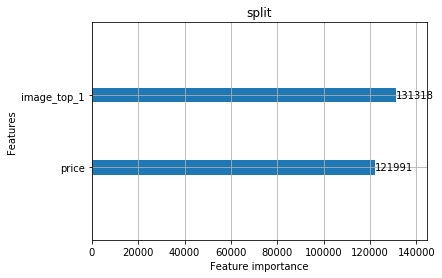

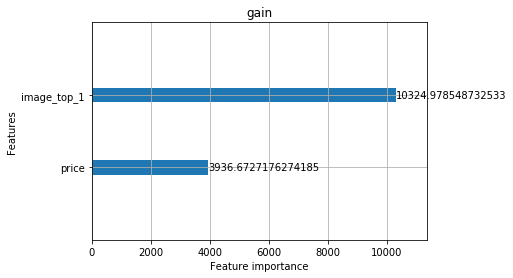

best iteration is 1034
best score is 0.24568382532443125
Training until validation scores don't improve for 50 rounds.
[50]	valid's rmse: 0.25197
[100]	valid's rmse: 0.248738
[150]	valid's rmse: 0.247407
[200]	valid's rmse: 0.246756
[250]	valid's rmse: 0.246389
[300]	valid's rmse: 0.246137
[350]	valid's rmse: 0.245947
[400]	valid's rmse: 0.245793
[450]	valid's rmse: 0.245684
[500]	valid's rmse: 0.245584
[550]	valid's rmse: 0.245502
[600]	valid's rmse: 0.245419
[650]	valid's rmse: 0.245366
[700]	valid's rmse: 0.245321
[750]	valid's rmse: 0.245286
[800]	valid's rmse: 0.24526
[850]	valid's rmse: 0.245221
[900]	valid's rmse: 0.245178
[950]	valid's rmse: 0.245161
[1000]	valid's rmse: 0.245146
[1050]	valid's rmse: 0.245136
[1100]	valid's rmse: 0.245118
[1150]	valid's rmse: 0.245111
[1200]	valid's rmse: 0.245108
[1250]	valid's rmse: 0.245092
[1300]	valid's rmse: 0.245101
Early stopping, best iteration is:
[1250]	valid's rmse: 0.245092


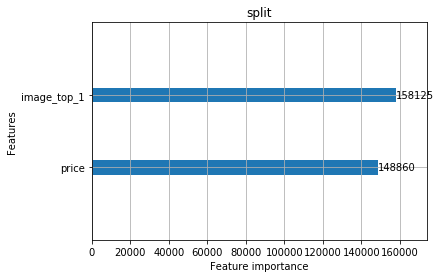

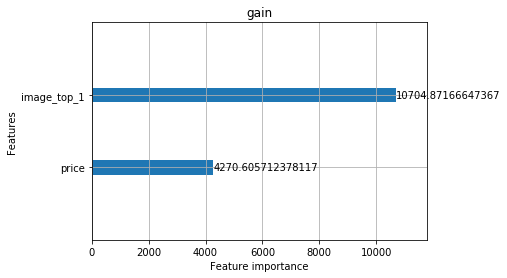

best iteration is 1250
best score is 0.24509168335582635
Best iterations:
[1034, 1250]
done


In [117]:
# Debug
train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
train = train.fillna(0)
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)
predictors = train.columns.tolist()

skf = KFold(n_splits=2)
lgb_models = []
best_iters = []
preds = pd.DataFrame()
count = 0

print(predictors)
for count, indices in enumerate(skf.split(train, y)):
    train_idx = indices[0]
    valid_idx = indices[1]
    Dtrain, Dvalid = get_lgb_train(train.iloc[train_idx,:], y.iloc[train_idx,:], train.iloc[valid_idx,:], y.iloc[valid_idx,:], predictors, categorical)
    del train, y; gc.collect()
    lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, isValid=True)
    del Dtrain, Dvalid; gc.collect()

    test = pd.read_csv('../input/test.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
    preds['lgb_pred_kfold_'+str(count)] = lgb_model.predict(test[predictors], num_iteration=best_iter)
    del test; gc.collect()
    
    lgb_models.append(lgb_model)
    best_iters.append(best_iter)
    train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': np.float32, 'image_top_1': np.float32})
    train.fillna(0)
    y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)

print('Best iterations:')
print(best_iters)

subs = pd.read_csv('../input/test.csv', usecols=['item_id'], nrows=100000)

pred_ensemble = np.zeros_like(preds['lgb_pred_kfold_0'].values)
for col in preds.columns:
    pred_ensemble += preds[col].values
pred_ensemble /= np.float(NFOLDS)
pred_ensemble = np.clip(pred_ensemble, 0, 1)
subs['deal_probability'] = pred_ensemble.flatten()

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
filename = '../subs/lightgbm_kfold_ensemble_'+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip',)

del subs, lgb_models, best_iters; gc.collect()

print('done')

C:\Users\osk\Anaconda3\envs\InqueryAnalysis\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	valid's rmse: 0.0955291
[200]	valid's rmse: 0.0931288
[300]	valid's rmse: 0.0910921
[400]	valid's rmse: 0.0892808
[500]	valid's rmse: 0.0880774


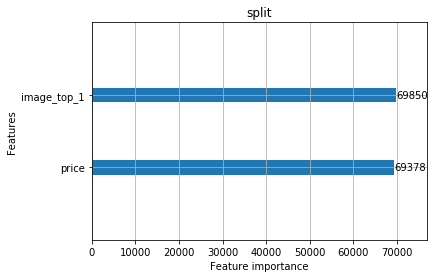

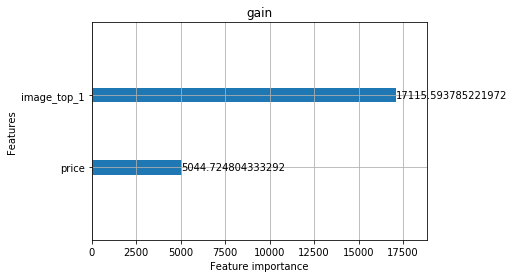

best iteration is 0


21

In [116]:
# Debug
# Example For whole traindata
bestiter = 500
train = pd.read_csv('../input/train.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
train = train.fillna(0)
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'], nrows=100000)
predictors = train.columns.tolist()

Dtrain, Dvalid = get_lgb_train(train, y, train.iloc[:2, :], y.iloc[:2, :], predictors, categorical)
del train, y; gc.collect()
lgb_model, best_iter = get_lgb_model(Dtrain, Dvalid, isValid=False, bestiter=bestiter)
del Dtrain; gc.collect()

subs = pd.read_csv('../input/test.csv', usecols=['item_id'], nrows=100000)
test = pd.read_csv('../input/test.csv', usecols=['price', 'image_top_1'], nrows=100000, dtype={'price': 'float32', 'image_top_1': 'float32'})
subs['deal_probability'] = lgb_model.predict(test[predictors], num_iteration=best_iter)

datetime = dt.now().strftime('%Y_%m%d_%H%M_%S')
filename = '../subs/lightgbm_wholedata_'+datetime+'.csv.gz'
subs.to_csv(filename, index=False, float_format='%.9f', compression='gzip',)

del subs, test; gc.collect()